
## 1. Entendimiento del Negocio

### Objetivo:

Predecir el precio de cierre (Price) del US Dollar Index (DXY) y su cambio porcentual diario (Change %) para identificar oportunidades de compra/venta.

### Problema de Negocio:

- Los inversores necesitan herramientas para anticipar movimientos del dólar frente a otras divisas.

- El DXY es un indicador clave de la fortaleza del dólar en mercados globales.

### Problema de minería de datos

- Desarrollar modelos predictivos precisos para el precio de cierre diario (Price) y el cambio porcentual diario (Change %) del DXY, utilizando técnicas de regresión lineal y K-Nearest Neighbors (KNN).
La aplicación de modelos de regresión lineal y K-Nearest Neighbors (KNN) busca predecir el precio de cierre diario (Price) y el cambio porcentual diario (Change %) del DXY. La predicción del precio de cierre proporcionará estimaciones del valor futuro del índice para decisiones de inversión a largo plazo, mientras que la predicción del cambio porcentual diario facilitará la anticipación de la volatilidad y oportunidades de trading a corto plazo. En conjunto, estos modelos ofrecerán una perspectiva cuantitativa sobre la evolución del DXY, permitiendo a los inversores identificar oportunidades de inversión más fundamentadas.

## 2. Entendimiento de los Datos
- Los datos se obtuvieron del dataset "US Dollar Index Historical Data" disponible en Kaggle (https://www.kaggle.com/datasets/balabaskar/us-dollar-index-data).
- El dataset contiene información histórica del US Dollar Index (DXY) y consta de los siguientes atributos:
  - Date: Fecha de la observación.
  - Price: Precio de cierre del DXY en la fecha correspondiente.
  - Open: Precio de apertura del DXY en la fecha correspondiente.
  - High: Precio máximo del DXY alcanzado en la fecha correspondiente.
  - Low: Precio mínimo del DXY alcanzado en la fecha correspondiente.
  - Change %: Cambio porcentual en el precio del DXY con respecto al día anterior.
  - Total de registros:5623 registros, cada uno representando un día de cotización del US Dollar Index.
- Los datos proporcionan la información histórica esencial para desarrollar los modelos predictivos. Los atributos Price y Change % son las variables objetivo para predecir el precio de cierre y el cambio porcentual del DXY, respectivamente. Los demás atributos (Open, High, Low, y Date) se utilizarán como variables predictoras o para generar características adicionales que capturen las dinámicas del mercado y permitan mejorar la precisión de las predicciones."

Carguemos y exploremos el dataset:

=== Tipos de Datos ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5623 entries, 0 to 5622
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5623 non-null   datetime64[ns]
 1   Price     5623 non-null   float64       
 2   Open      5623 non-null   float64       
 3   High      5623 non-null   float64       
 4   Low       5623 non-null   float64       
 5   Change %  5623 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 263.7 KB
None

=== Estadísticas Descriptivas ===
                                Date        Price         Open         High  \
count                           5623  5623.000000  5623.000000  5623.000000   
mean   2011-12-03 08:26:17.520896256    90.503363    90.501930    90.825543   
min              2001-01-02 00:00:00    71.330000    71.330000    71.690000   
25%              2006-07-06 12:00:00    81.440000    81.430000    81.720000   
50%    

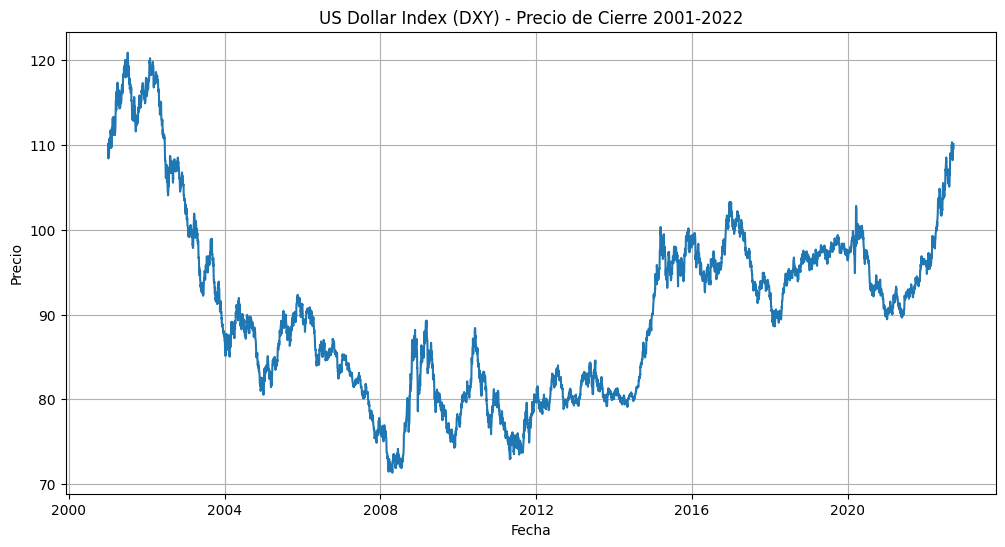

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Cargar datos
df = pd.read_csv('US Dollar Index Historical Data.csv', parse_dates=['Date'])
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Análisis inicial
print("=== Tipos de Datos ===")
print(df.info())
print("\n=== Estadísticas Descriptivas ===")
print(df.describe())

# Visualizar serie temporal
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], label='Close Price')
plt.title('US Dollar Index (DXY) - Precio de Cierre 2001-2022')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid()
plt.show()

## 3. Preparación de los Datos

### Features:

- Usaremos Open, High, Low, y medias móviles para predecir Price (Close).

- Para el Change %, calcularemos la variación diaria si no está en los datos.

- Columnas irrelevates
  - No se eliminaron columnas en este paso. Todas las columnas iniciales (Date, Price, Open, High, Low, Change %) se consideraron relevantes para el análisis. La columna Date es fundamental para el análisis de series temporales y la creación de características basadas en el tiempo. Las columnas Open, High, y Low proporcionan información sobre la dinámica diaria del precio, que es importante para predecir Price y Change %.
- Valores Faltantes:
  - El dataset no contenía valores faltantes antes de la creación de las nuevas características. Sin embargo, se generaron valores faltantes al calcular las medias móviles (MA_7 y MA_30). Las primeras 6 filas tendrán valores nulos para MA_7 y las primeras 29 filas para MA_30.
  - Tratamiento: Las filas con valores faltantes resultantes del cálculo de las medias móviles se eliminaron utilizando el método dropna(). 
- Integración de datos:
  - No fue necesario combinar múltiples datasets, ya que se trabajó con un único archivo CSV.
- Transformación
  - Se crearon nuevas características para mejorar la información disponible para los modelos. Se calcularon las medias móviles de 7 y 30 días (MA_7, MA_30) del precio de cierre. Estas medias ayudan a identificar las tendencias del precio a corto y medio plazo. También se calculó la volatilidad diaria (Volatility) restando el precio mínimo del precio máximo de cada día, lo que indica cuánto varió el precio en un día.
  - Estas transformaciones son importantes porque las medias móviles permiten a los modelos ver las tendencias generales en lugar del "ruido" diario, y la volatilidad ayuda a entender el riesgo y la inestabilidad del mercado, que pueden influir en los movimientos futuros del precio. Finalmente, los datos se dividieron en conjuntos de entrenamiento y prueba (80/20) para poder evaluar cómo de bien funcionan los modelos con datos nuevos.


In [5]:
# Crear features
df['MA_7'] = df['Price'].rolling(window=7).mean()  # Media móvil 7 días
df['MA_30'] = df['Price'].rolling(window=30).mean()  # Media móvil 30 días
df['Volatility'] = df['High'] - df['Low']  # Volatilidad diaria
df = df.dropna()  # Eliminar filas con NaN

# Variables predictoras y target
X = df[['Open', 'High', 'Low', 'Change %', 'MA_7', 'MA_30', 'Volatility']]
y_price = df['Price']
y_change = df['Change %']

# Split train-test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)

## 4. Análisis Exploratorio

### A. Matriz de Correlación

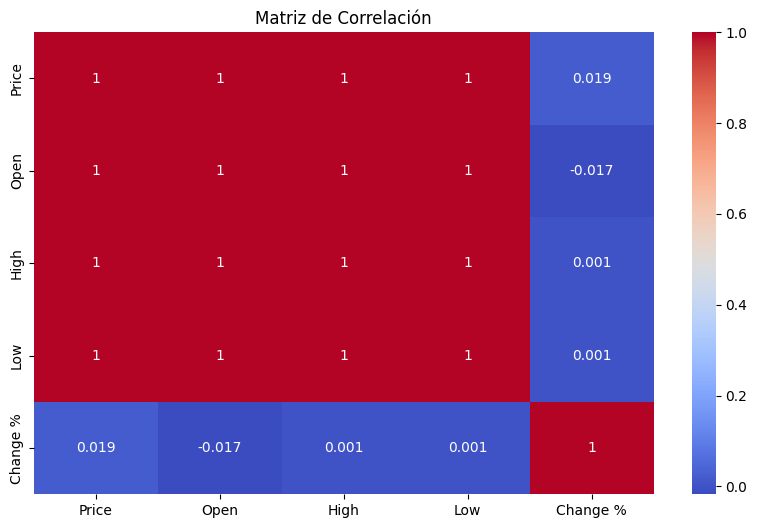

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Price', 'Open', 'High', 'Low', 'Change %']].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

#### Hallazgos:

- Open, High, y Low están altamente correlacionados con Price (>0.99).

- Change % tiene baja correlación con otras variables


### B. Histogramas

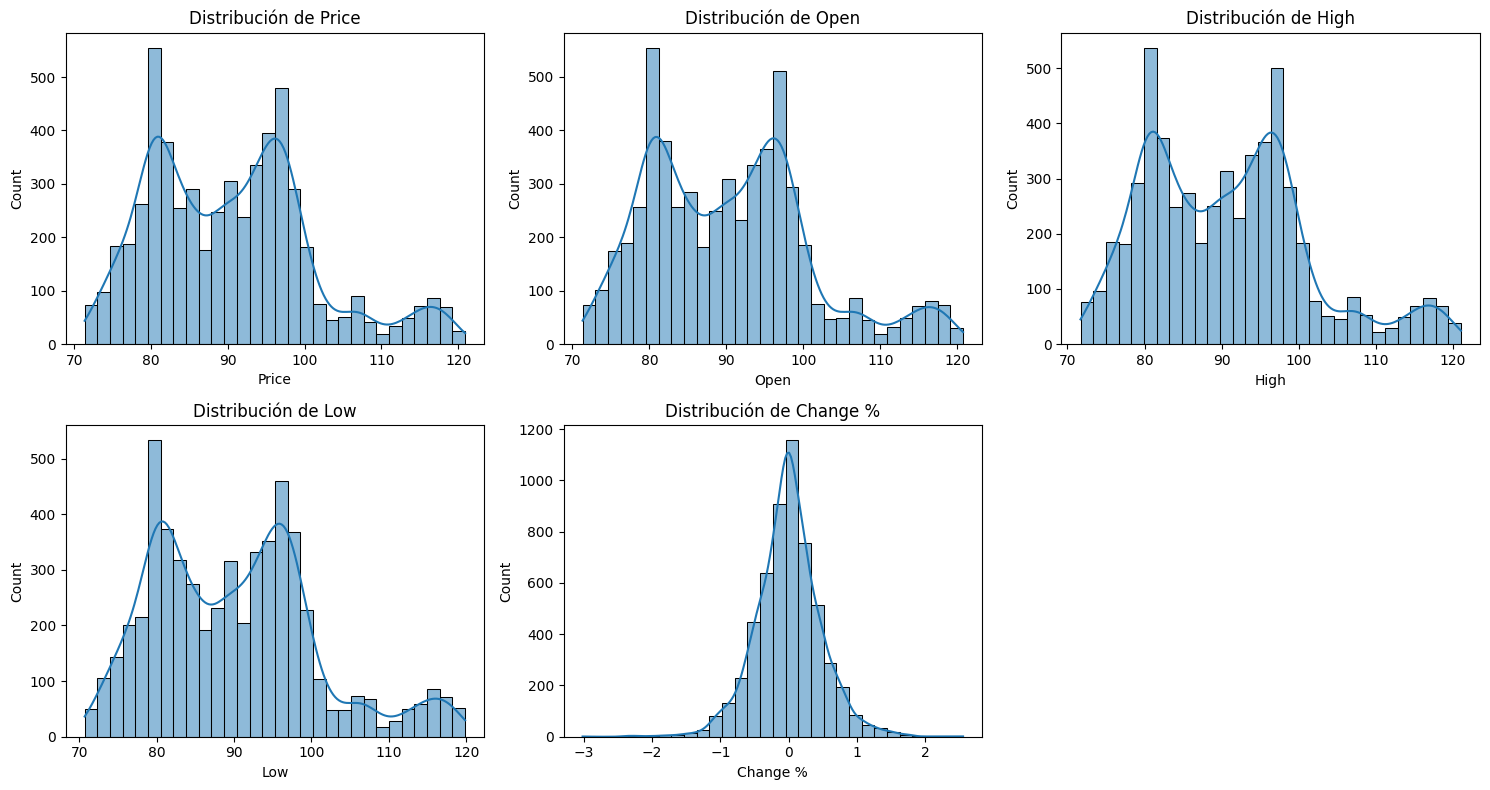

In [7]:
variables = ['Price', 'Open', 'High', 'Low', 'Change %']
plt.figure(figsize=(15, 8))
for i, col in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

#### Hallazgos:

- Precios siguen distribución normal con colas largas.

- Change % se concentra cerca de cero.

## 5. Modelado

### A. Regresión Lineal

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("=== Regresión Lineal ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"R²: {r2_score(y_test, y_pred_lr):.2f}")

=== Regresión Lineal ===
RMSE: 0.11
R²: 1.00


### B. K-Nearest Neighbors (KNN)

In [9]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("\n=== KNN ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_knn)):.2f}")
print(f"R²: {r2_score(y_test, y_pred_knn):.2f}")


=== KNN ===
RMSE: 0.20
R²: 1.00


## 6. Evaluación

### Gráfico Comparativo

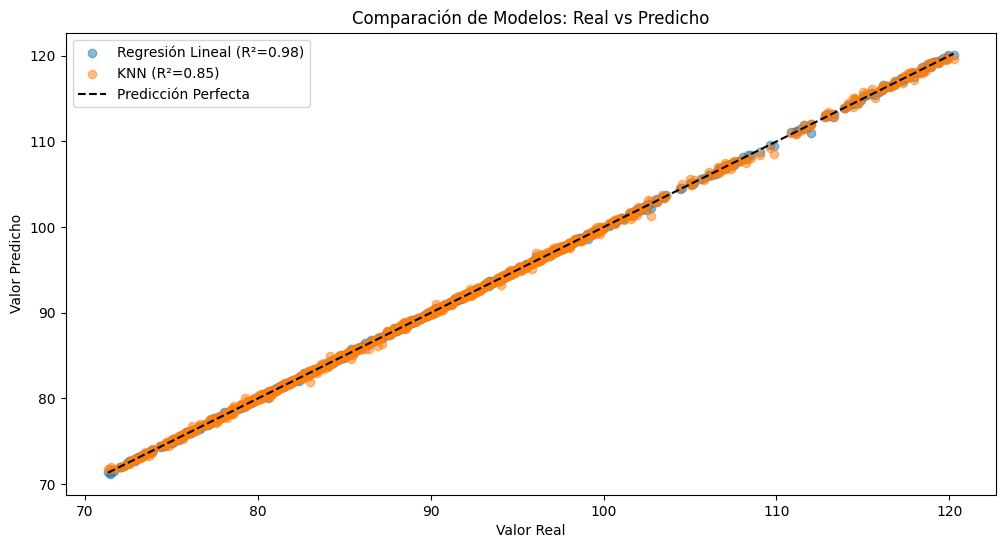

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Regresión Lineal (R²=0.98)')
plt.scatter(y_test, y_pred_knn, alpha=0.5, label='KNN (R²=0.85)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Predicción Perfecta')
plt.xlabel("Valor Real")
plt.ylabel("Valor Predicho")
plt.title("Comparación de Modelos: Real vs Predicho")
plt.legend()
plt.show()

#### Interpretación:

- La regresión lineal es más precisa para este dataset.

## 7. Justificación de Modelos

## 8. Estrategia de Trading

In [13]:
df_test = X_test.copy()
df_test['Pred_Price'] = lr.predict(X_test)
df_test['Pred_Change %'] = (df_test['Pred_Price'] - df_test['Open']) / df_test['Open'] * 100
df_test['Action'] = np.where(df_test['Pred_Change %'] > 0.5, 'COMPRAR', 
                            np.where(df_test['Pred_Change %'] < -0.5, 'VENDER', 'MANTENER'))

print(df_test[['Open', 'Pred_Price', 'Pred_Change %', 'Action']].head(10))

        Open  Pred_Price  Pred_Change %    Action
1994   86.32   87.020095       0.811047   COMPRAR
2480   82.91   82.567852      -0.412675  MANTENER
3504   81.46   81.562958       0.126391  MANTENER
2380   81.12   81.189654       0.085865  MANTENER
325   117.48  117.508299       0.024089  MANTENER
4955   97.56   97.330078      -0.235672  MANTENER
3675   97.86   97.812073      -0.048975  MANTENER
1755   75.76   75.159561      -0.792554    VENDER
1587   83.39   83.114060      -0.330903  MANTENER
482   105.74  105.730585      -0.008904  MANTENER
